In [1]:
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from scipy.stats import uniform
from scipy.stats import randint
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
data = pd.read_csv('Pt_nanoparticle_subset.csv', index_col=0)
data.head()

,N_total,N_bulk,N_surface,R_min,R_max,R_diff,R_avg,R_std,R_skew,R_kurt,...,q6q6_T8,q6q6_T9,q6q6_T10,q6q6_T11,q6q6_T12,Surf_defects_mol,Surf_micros_mol,Surf_facets_mol,Total_E,Formation_E
ID,,,,,,,,,,,,,,,,,,,,,
1,1732,1129,603,15.1180,18.9872,3.8692,17.2471,0.6262,-0.1372,0.1226,...,64,88,52,43,40,0.0000,121.5956,267.1222,-9237.3055,756.3345
2,1755,1150,605,15.3043,20.0506,4.7463,17.3469,0.6597,0.2938,0.3970,...,69,74,44,30,50,0.6383,117.4488,266.1747,-9335.3608,790.9892
3,4672,3456,1216,21.5357,27.5179,5.9822,24.5075,0.9193,-0.0729,0.1330,...,261,258,243,182,696,0.4796,84.8806,205.7275,-25287.5650,1669.8750
4,6823,5122,1701,23.3351,35.9820,12.6469,28.0471,1.9581,0.4768,0.2181,...,417,488,419,400,1730,0.6567,87.3462,189.9616,-37049.1710,2319.5390
5,10733,8349,2384,25.7149,40.8339,15.1190,32.7271,2.1220,-0.3342,0.2877,...,683,782,685,713,4006,0.6262,83.9156,163.6563,-58602.2500,3327.1600


In [3]:
X = data.iloc[:,3:10]
y = data.iloc[:,-1]
min_max_scaler = preprocessing.MinMaxScaler()
X = pd.DataFrame(min_max_scaler.fit_transform(X.values),columns=X.columns)
X.head()

,R_min,R_max,R_diff,R_avg,R_std,R_skew,R_kurt
0,0.384908,0.183569,0.046382,0.323010,0.016219,0.529445,0.089511
1,0.390694,0.203226,0.069190,0.326296,0.020016,0.631094,0.105145
2,0.584235,0.341265,0.101329,0.562090,0.049439,0.544610,0.090103
3,0.640123,0.497730,0.274641,0.678646,0.167177,0.674253,0.094952
4,0.714037,0.587421,0.338927,0.832755,0.185753,0.482984,0.098917


In [4]:
from sklearn.model_selection import quasi_train_test_split
X_train, X_test, y_train, y_test = quasi_train_test_split(X,y, train_size=0.7, random_state=0)

In [5]:
# Import library for Linear Regression
from sklearn.linear_model import LinearRegression

# Create a Linear regressor
lm = LinearRegression()

# Train the model using the training sets 
lm.fit(X_train, y_train)
lm.intercept_

525261.811368738

In [6]:
#Converting the coefficient values to a dataframe
coeffcients = pd.DataFrame([X_train.columns,lm.coef_]).T
coeffcients = coeffcients.rename(columns={0: 'Attribute', 1: 'Coefficients'})
coeffcients

,Attribute,Coefficients
0,R_min,-3.98525e+06
1,R_max,6.69504e+06
2,R_diff,-4.75919e+06
3,R_avg,5016.23
4,R_std,-848.338
5,R_skew,-244.937
6,R_kurt,183.833


In [7]:
# Model prediction on train data
y_pred = lm.predict(X_train)
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: 0.9637035657732267
Adjusted R^2: 0.9634215734984349
MAE: 187.78941770436805
MSE: 55625.68969782679
RMSE: 235.85099045335127


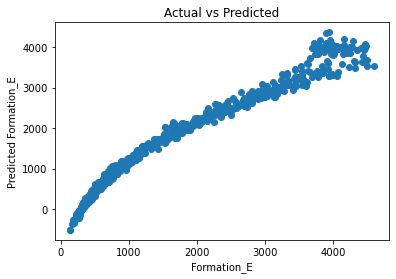

In [8]:
# Visualizing the differences between actual prices and predicted values
plt.scatter(y_train, y_pred)
plt.xlabel("Formation_E")
plt.ylabel("Predicted Formation_E")
plt.title("Actual vs Predicted")
plt.show()

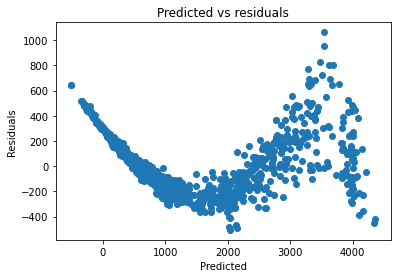

In [9]:
# Checking residuals
plt.scatter(y_pred,y_train-y_pred)
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

C:\Users\danyang\anaconda3\envs\quasienv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


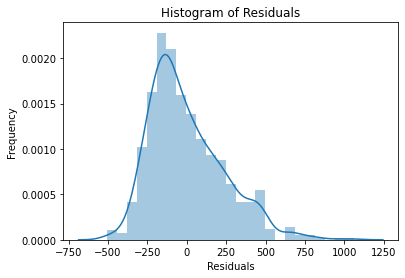

In [10]:
# Checking Normality of errors
sns.distplot(y_train-y_pred)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

In [11]:
# Predicting Test data with the model
y_test_pred = lm.predict(X_test)
# Model Evaluation
acc_linreg = metrics.r2_score(y_test, y_test_pred)
print('R^2:', acc_linreg)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

R^2: 0.9639424195132643
Adjusted R^2: 0.963283403681914
MAE: 186.03426055058807
MSE: 55755.49016328799
RMSE: 236.12600484336323


In [12]:
X.shape

(1300, 7)

In [13]:
X_train1, X_test1, y_train1, y_test1 = quasi_train_test_split(X,y, train_size=0.2, random_state=0)
lm1 = LinearRegression()
lm1.fit(X_train1, y_train1)
lm1.intercept_

-479708.5652639711

In [14]:
y_pred1 = lm1.predict(X)
acc_linreg1 = metrics.r2_score(y, y_pred1)
print('R^2:', acc_linreg1)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y, y_pred1))*(len(y)-1)/(len(y)-X.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y, y_pred1))
print('MSE:',metrics.mean_squared_error(y, y_pred1))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y, y_pred1)))

R^2: 0.9632764721577876
Adjusted R^2: 0.9630775056756703
MAE: 189.14749904173974
MSE: 56436.275626589246
RMSE: 237.56320343561046
